<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_2_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# T81-558: Applications of Deep Neural Networks
**Module 10: Time Series in Keras**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 10 Material

* Part 10.1: Time Series Data Encoding for Deep Learning [[Video]](https://www.youtube.com/watch?v=dMUmHsktl04&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_1_timeseries.ipynb)
* **Part 10.2: Programming LSTM with Keras and TensorFlow** [[Video]](https://www.youtube.com/watch?v=wY0dyFgNCgY&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_2_lstm.ipynb)
* Part 10.3: Text Generation with Keras and TensorFlow [[Video]](https://www.youtube.com/watch?v=6ORnRAz3gnA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_3_text_generation.ipynb)
* Part 10.4: Image Captioning with Keras and TensorFlow [[Video]](https://www.youtube.com/watch?v=NmoW_AYWkb4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_4_captioning.ipynb)
* Part 10.5: Temporal CNN in Keras and TensorFlow [[Video]](https://www.youtube.com/watch?v=i390g8acZwk&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_5_temporal_cnn.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


# Part 10.2: Programming LSTM with Keras and TensorFlow

So far the neural networks that we’ve examined have always had forward connections.  The input layer always connects to the first hidden layer.  Each hidden layer always connects to the next hidden layer.  The final hidden layer always connects to the output layer.  This manner to connect layers is the reason that these networks are called “feedforward.”  Recurrent neural networks are not so rigid, as backward connections are also allowed. A recurrent connection links a neuron in a layer to either a previous layer or the neuron itself.  Most recurrent neural network architectures maintain state in the recurrent connections.  Feedforward neural networks don’t maintain any state.  A recurrent neural network’s state acts as a sort of short-term memory for the neural network.  Consequently, a recurrent neural network will not always produce the same output for a given input.

Recurrent neural networks do not force the connections to flow only from one layer to the next, from input layer to output layer.  A recurrent connection occurs when a connection is formed between a neuron and one of the following other types of neurons:

* The neuron itself
* A neuron on the same level
* A neuron on a previous level

Recurrent connections can never target the input neurons or the bias neurons.  
The processing of recurrent connections can be challenging. Because the recurrent links create endless loops, the neural network must have some way to know when to stop.  A neural network that entered an endless loop would not be useful.  To prevent endless loops, we can calculate the recurrent connections with the following three approaches:

* Context neurons
* Calculating output over a fixed number of iterations
* Calculating output until neuron output stabilizes

The context neuron is a special neuron type that remembers its input and provides that input as its output the next time that we calculate the network.  For example, if we gave a context neuron 0.5 as input, it would output 0.  Context neurons always output 0 on their first call.  However, if we gave the context neuron a 0.6 as input, the output would be 0.5.  We never weight the input connections to a context neuron, but we can weight the output from a context neuron just like any other connection in a network.  

Context neurons allow us to calculate a neural network in a single feedforward pass.  Context neurons usually occur in layers.  A layer of context neurons will always have the same number of context neurons as neurons in its source layer, as demonstrated by Figure 10.CTX.

**Figure 10.CTX: Context Layers**
![Context Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_context_layer.png "Context Layers")

As you can see from the above layer, two hidden neurons that are labeled hidden 1 and hidden 2 directly connect to the two context neurons.  The dashed lines on these connections indicate that these are not weighted connections. These weightless connections are never dense.  If these connections were dense, hidden 1 would be connected to both hidden 1 and hidden 2.  However, the direct connection simply joins each hidden neuron to its corresponding context neuron.  The two context neurons form dense, weighted connections to the two hidden neurons.  Finally, the two hidden neurons also form dense connections to the neurons in the next layer.  The two context neurons would form two connections to a single neuron in the next layer, four connections to two neurons, six connections to three neurons, and so on.

You can combine context neurons with the input, hidden, and output layers of a neural network in many different ways. 

# Understanding LSTM

Some useful resources on LSTM/recurrent neural networks.

* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Recurrent Neural Networks in TensorFlow](https://www.tensorflow.org/versions/r0.11/tutorials/recurrent/index.html)

Long Short Term Neural Network (LSTM) are a type of recurrent unit that is often used with deep neural networks.[[Cite:hochreiter1997long]](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320)  For TensorFlow, LSTM can be thought of as a layer type that can be combined with other layer types, such as dense.  LSTM makes use two transfer function types internally.  

The first type of transfer function is the sigmoid.  This transfer function type is used form gates inside of the unit.  The sigmoid transfer function is given by the following equation:

$ \mbox{S}(t) = \frac{1}{1 + e^{-t}} $

The second type of transfer function is the hyperbolic tangent (tanh) function.  This function is used to scale the output of the LSTM, similarly to how other transfer functions have been used in this course.  

The graphs for these functions are shown here:

Sigmoid


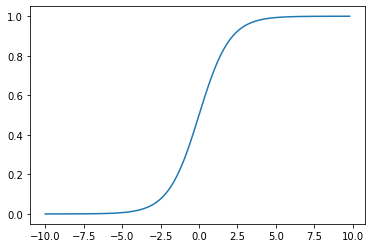

Hyperbolic Tangent(tanh)


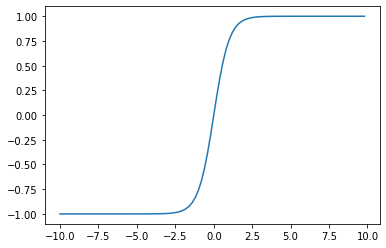

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

def f2(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a

x = np.arange(-10., 10., 0.2)
y1 = sigmoid(x)
y2 = f2(x)

print("Sigmoid")
plt.plot(x,y1)
plt.show()

print("Hyperbolic Tangent(tanh)")
plt.plot(x,y2)
plt.show()

Both of these two functions compress their output to a specific range.  For the sigmoid function, this range is 0 to 1.  For the hyperbolic tangent function, this range is -1 to 1.

LSTM maintains an internal state and produces an output.  The following diagram shows an LSTM unit over three time slices: the current time slice (t), as well as the previous (t-1) and next (t+1) slice, as demonstrated by Figure 10.LSTM.

**Figure 10.LSTM: LSTM Layers**
![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm1.png "LSTM Layers")

The values $\hat{y}$ are the output from the unit, the values ($x$) are the input to the unit and the values $c$ are the context values.  Both the output and context values are always fed to the next time slice.  The context values allow the network to maintain state between calls.  Figure 10.ILSTM shows the internals of a LSTM layer.

**Figure 10.ILSTM: Inside a LSTM Layer**
![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm2.png "Inside the LSTM")

LSTM is made up of three gates:

* Forget Gate ($f_t$) - Controls if/when the context is forgotten. (MC)
* Input Gate ($i_t$) - Controls if/when a value should be remembered by the context. (M+/MS)
* Output Gate ($o_t$) - Controls if/when the remembered value is allowed to pass from the unit. (RM)

Mathematically, the above diagram can be thought of as the following:

**These are vector values.**

First, calculate the forget gate value.  This gate determines if the short term memory is forgotten.  The value $b$ is a bias, just like the bias neurons we saw before.  Except LSTM has a bias for every gate: $b_t$, $b_i$, and $b_o$.

$ f_t = S(W_f \cdot [\hat{y}_{t-1}, x_t] + b_f) $

$ i_t = S(W_i \cdot [\hat{y}_{t-1},x_t] + b_i) $

$ \tilde{C}_t = \tanh(W_C \cdot [\hat{y}_{t-1},x_t]+b_C) $

$ C_t = f_t \cdot C_{t-1}+i_t \cdot \tilde{C}_t $

$ o_t = S(W_o \cdot [\hat{y}_{t-1},x_t] + b_o ) $

$ \hat{y}_t = o_t \cdot \tanh(C_t) $


# Simple TensorFlow LSTM Example

The following code creates the LSTM network.  This is an example of RNN classification.  The following code trains on a data set (x) with a max sequence size of 6 (columns) and 6 training elements (rows)

In [3]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
import numpy as np

max_features = 4 # 0,1,2,3 (total of 4)
x = [
    [[0],[1],[1],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0]],
    [[0],[0],[0],[0],[3],[3]],
    [[0],[2],[2],[0],[0],[0]],
    [[0],[0],[3],[3],[0],[0]],
    [[0],[0],[0],[0],[1],[1]]
]
x = np.array(x,dtype=np.float32)
y = np.array([1,2,3,2,3,1],dtype=np.int32)

# Convert y2 to dummy variables
y2 = np.zeros((y.shape[0], max_features),dtype=np.float32)
y2[np.arange(y.shape[0]), y] = 1.0
print(y2)

print('Build model...')
model = Sequential()
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 1)))
model.add(Dense(4, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x,y2,epochs=200)
pred = model.predict(x)
predict_classes = np.argmax(pred,axis=1)
print("Predicted classes: {}",predict_classes)
print("Expected classes: {}",predict_classes)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
Build model...
Train...
Train on 6 samples
Epoch 1/200
6/6 [==============================] - 3s 505ms/sample - loss: 0.6913 - accuracy: 0.5417
Epoch 2/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.6886 - accuracy: 0.5833
Epoch 3/200
6/6 [==============================] - 0s 4ms/sample - loss: 0.6831 - accuracy: 0.7083
Epoch 4/200
6/6 [==============================] - 0s 4ms/sample - loss: 0.6673 - accuracy: 0.7083
Epoch 5/200
6/6 [==============================] - 0s 3ms/sample - loss: 0.6586 - accuracy: 0.6667
Epoch 6/200
6/6 [==============================] - 0s 3ms/sample - loss: 0.6506 - accuracy: 0.7500
Epoch 7/200
6/6 [==============================] - 0s 4ms/sample - loss: 0.6456 - accuracy: 0.7083
Epoch 8/200
6/6 [==============================] - 0s 3ms/sample - loss: 0.6515 - accuracy: 0.6250
Epoch 9/200
6/6 [==============================] - 0s 7ms/sample - loss:

Epoch 82/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.3926 - accuracy: 0.8750
Epoch 83/200
6/6 [==============================] - 0s 3ms/sample - loss: 0.2640 - accuracy: 0.9167
Epoch 84/200
6/6 [==============================] - 0s 4ms/sample - loss: 0.4553 - accuracy: 0.7500
Epoch 85/200
6/6 [==============================] - 0s 3ms/sample - loss: 0.2555 - accuracy: 0.9583
Epoch 86/200
6/6 [==============================] - 0s 3ms/sample - loss: 0.4095 - accuracy: 0.8333
Epoch 87/200
6/6 [==============================] - 0s 4ms/sample - loss: 0.3975 - accuracy: 0.8333
Epoch 88/200
6/6 [==============================] - 0s 5ms/sample - loss: 0.2851 - accuracy: 0.9583
Epoch 89/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.2500 - accuracy: 0.9583
Epoch 90/200
6/6 [==============================] - 0s 4ms/sample - loss: 0.2910 - accuracy: 0.8750
Epoch 91/200
6/6 [==============================] - 0s 3ms/sample - loss: 0.3364 - accuracy: 0.8750


Epoch 164/200
6/6 [==============================] - 0s 2ms/sample - loss: 0.1198 - accuracy: 1.0000
Epoch 165/200
6/6 [==============================] - 0s 3ms/sample - loss: 0.2577 - accuracy: 0.9167
Epoch 166/200
6/6 [==============================] - 0s 3ms/sample - loss: 0.1335 - accuracy: 1.0000
Epoch 167/200
6/6 [==============================] - 0s 3ms/sample - loss: 0.3546 - accuracy: 0.8333
Epoch 168/200
6/6 [==============================] - 0s 3ms/sample - loss: 0.2348 - accuracy: 0.9167
Epoch 169/200
6/6 [==============================] - 0s 1ms/sample - loss: 0.1281 - accuracy: 1.0000
Epoch 170/200
6/6 [==============================] - 0s 4ms/sample - loss: 0.1660 - accuracy: 1.0000
Epoch 171/200
6/6 [==============================] - 0s 4ms/sample - loss: 0.2184 - accuracy: 0.9167
Epoch 172/200
6/6 [==============================] - 0s 4ms/sample - loss: 0.1036 - accuracy: 1.0000
Epoch 173/200
6/6 [==============================] - 0s 4ms/sample - loss: 0.2024 - accurac

In [4]:
def runit(model, inp):
    inp = np.array(inp,dtype=np.float32)
    pred = model.predict(inp)
    return np.argmax(pred[0])

print( runit( model, [[[0],[0],[0],[0],[0],[1]]] ))


1


# Sun Spots Example

An example of RNN regression to predict sunspots.  The data files needed for this example can be found at the following location.

* [Sunspot Data Files](http://www.sidc.be/silso/datafiles#total)
* [Download Daily Sunspots](http://www.sidc.be/silso/INFO/sndtotcsv.php) - 1/1/1818 to now.

The following code is used to load the sunspot file:


In [5]:
import pandas as pd
import os

# Replacce the following path with your own file. It can be downloaded from:
# http://www.sidc.be/silso/INFO/sndtotcsv.php

if COLAB:
    PATH = "/content/drive/My Drive/Colab Notebooks/data/"
else:
    PATH = "./data/"
    
filename = os.path.join(PATH,"SN_d_tot_V2.0.csv")    
names = ['year', 'month', 'day', 'dec_year', 'sn_value' , 
         'sn_error', 'obs_num']
df = pd.read_csv(filename,sep=';',header=None,names=names,
                 na_values=['-1'], index_col=False)

print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

Starting file:
   year  month  day  dec_year  sn_value  sn_error  obs_num
0  1818      1    1  1818.001        -1       NaN        0
1  1818      1    2  1818.004        -1       NaN        0
2  1818      1    3  1818.007        -1       NaN        0
3  1818      1    4  1818.010        -1       NaN        0
4  1818      1    5  1818.012        -1       NaN        0
5  1818      1    6  1818.015        -1       NaN        0
6  1818      1    7  1818.018        -1       NaN        0
7  1818      1    8  1818.021        65      10.2        1
8  1818      1    9  1818.023        -1       NaN        0
9  1818      1   10  1818.026        -1       NaN        0
Ending file:
       year  month  day  dec_year  sn_value  sn_error  obs_num
73769  2019     12   22  2019.974         0       0.0       17
73770  2019     12   23  2019.977         0       0.0       24
73771  2019     12   24  2019.979        16       1.0       10
73772  2019     12   25  2019.982        23       2.2        7
73773  2

As you can see, there is quite a bit of missing data near the end of the file.  We would like to find the starting index where the missing data no longer occurs.  This is somewhat sloppy, it would be better to find a use for the data between missing values.  However, the point of this example is show how to use LSTM with a somewhat simple time-series.

In [6]:
start_id = max(df[df['obs_num'] == 0].index.tolist())+1  # Find the last zero and move one beyond
print(start_id)
df = df[start_id:] # Trim the rows that have missing observations

11314


In [7]:
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year']<2000]
df_test = df[df['year']>=2000]

spots_train = df_train['sn_value'].tolist()
spots_test = df_test['sn_value'].tolist()

print("Training set has {} observations.".format(len(spots_train)))
print("Test set has {} observations.".format(len(spots_test)))

Training set has 55160 observations.
Test set has 7305 observations.


In [8]:
import numpy as np

def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
    
    
SEQUENCE_SIZE = 10
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (55150, 10, 1)
Shape of test set: (7295, 10, 1)


In [9]:
x_train

array([[[353.],
        [240.],
        [275.],
        ...,
        [340.],
        [238.],
        [287.]],

       [[240.],
        [275.],
        [352.],
        ...,
        [238.],
        [287.],
        [294.]],

       [[275.],
        [352.],
        [268.],
        ...,
        [287.],
        [294.],
        [342.]],

       ...,

       [[138.],
        [141.],
        [128.],
        ...,
        [116.],
        [ 95.],
        [ 85.]],

       [[141.],
        [128.],
        [130.],
        ...,
        [ 95.],
        [ 85.],
        [103.]],

       [[128.],
        [130.],
        [123.],
        ...,
        [ 85.],
        [103.],
        [ 66.]]])

In [10]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

print('Build model...')
model = Sequential()
model.add(LSTM(64, dropout=0.0, recurrent_dropout=0.0,input_shape=(None, 1)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=1000)

Build model...
Train...
Train on 55150 samples, validate on 7295 samples
Epoch 1/1000
55150/55150 - 13s - loss: 1312.6864 - val_loss: 190.2033
Epoch 2/1000
55150/55150 - 8s - loss: 513.1618 - val_loss: 188.5868
Epoch 3/1000
55150/55150 - 8s - loss: 510.8469 - val_loss: 191.0815
Epoch 4/1000
55150/55150 - 8s - loss: 506.8735 - val_loss: 215.0268
Epoch 5/1000
55150/55150 - 8s - loss: 503.7439 - val_loss: 193.7987
Epoch 6/1000
55150/55150 - 8s - loss: 504.5192 - val_loss: 199.2520
Epoch 7/1000
Restoring model weights from the end of the best epoch.
55150/55150 - 8s - loss: 502.6547 - val_loss: 198.9333
Epoch 00007: early stopping


In [11]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 13.732691339581104
